In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import ast
import plotly.express as px
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In this notebook, I'll attempt visualizing data of models available in [Huggingface Modelhub].(https://huggingface.co/models)

There are two files available under the dataset:
- huggingface_models.csv : Primary file which contains metadata information like model name, tags, last modified and filenames
- huggingfacemodelcardreadme.csv : Detailed file containing README.md contents if available for a particular model

We'll start with loading the csv `huggingface_models.csv` file as a pandas dataframe. Let's start with looking at some sample of rows in the dataset.

In [ ]:
df = pd.read_csv("../input/huggingface-modelhub/huggingface_models.csv")

In [ ]:
df.sample(3)

These are the column descriptions of the dataset:
- **modelId**: ID of the model as present on HF website
- **lastModified**: Time when this model was last modified
- **tags**: Tags associated with the model (provided by mantainer)
- **pipeline_tag**: If exists, denotes which pipeline this model could be used with
- **files**: List of available files in the model repo
- **publishedBy**: Custom column derived from modelID, specifying who published this model
- **downloads_last_month**: Number of times the model has been downloaded in last month.
- **library**: Name of library the model belongs to eg: transformers, spacy, timm etc.

Column **tags** and **files** are arrays, so we need to process them a bit differently like this:

In [ ]:
df["tags"] = df["tags"].apply(ast.literal_eval)
df["files"] = df["files"].apply(ast.literal_eval)

### How many models are available for different pipelines?

In [ ]:
px.bar(df["pipeline_tag"].value_counts().reset_index(), x="index", y="pipeline_tag", labels={"index": "pipeline-tag", "pipeline_tag": "Count"})

### Which are the Top-20 Most Downloaded models?
"most downloaded" refers to the past-1month download count available when the dataset was created.

In [ ]:
 px.bar(df.sort_values("downloads_last_month", ascending=False)[:20], x="modelId", y="downloads_last_month")

Observations:
- **8 out of 20** most downloaded models are community provided(including companies like google). Rest are uploaded by Huggingface.

#### Top20 most downloaded models provided by community
Excluding Huggingface's provided models, which are the most downloaded models

In [ ]:
 px.bar(df[df["publishedBy"]!="huggingface"].sort_values("downloads_last_month", ascending=False)[:20], x="modelId", y="downloads_last_month")

Observations:
1. [herbert-base-cased](https://huggingface.co/allegro/herbert-base-cased) is a model trained on Polish language. It's graph looks like this:
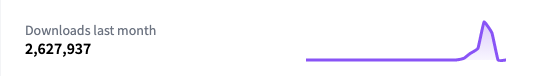
2. [sentence-transformer model](https://huggingface.co/sentence-transformers/paraphrase-xlm-r-multilingual-v1) is a paraphrasing model. It's graph looks like this:
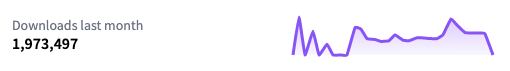

It's likely and possible that herbert downloads could be a part of an automated pipeline which leads to such high peak of downloads like [Apple was accidentlly doing to Huggingface](https://twitter.com/julien_c/status/1173669642629537795) 2 years back. Note that in the live downloads graphs above, data has changed since it's a current screenshot, whereas the dataset was created earlier.

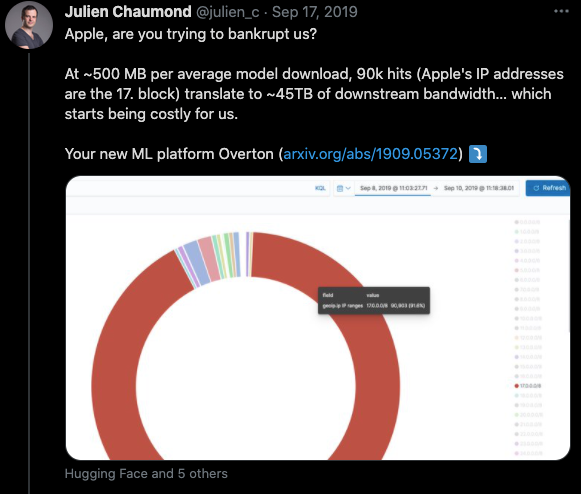

### Who has published most number of models?

In [ ]:
 px.bar(df["publishedBy"].value_counts()[:20].reset_index(), x="index", y="publishedBy", labels={"index": "Top 20 publishers", "publishedBy": "Count"})

Observations:
- Some of the publishers are companies whereas some are individual contributors. It's difficult to identify the difference just by this dataset itself.
- Some of the individual publishers *work* at Huggingface

### Which publishers models are most downloaded overall?
Publisher vs Total Download count of all models. Top-20

In [ ]:
px.bar(df[["publishedBy", "downloads_last_month"]]
       .groupby("publishedBy").sum().reset_index().sort_values("downloads_last_month", ascending=False)[:20],
       x="publishedBy", y="downloads_last_month", labels={"y": "Total downloads last month"})

Observations:
- **Helsinki-NLP** stands out in top charts having more number of models available and downloads as well.
- **sentence-transformers** ranked 12 in number of models available but leads in downloads, following huggingface.
- **huggingtweets** contains generative models, each finetuned to a specific persona, and hence leads in number of available models


### What percentage of total model downloads are from huggingface?

In [ ]:
df["hf_or_not"] = df["publishedBy"].apply(lambda x: "huggingface" if x=="huggingface" else "others")
px.pie(df, values="downloads_last_month", names="hf_or_not", title="Share of Downloads (HuggingFace models vs Others)")

### Pytorch or Tensorflow?

#### Identifying using available 'tags'

In [ ]:
def is_tf_torch_present(x):
    if "tf" in x and "pytorch" in x:
        return "Both"
    elif "pytorch" in x:
        return "PyTorch"
    elif "tf" in x:
        return "Tensorflow"
    return None
df["tf_torch"] = df["tags"].apply(lambda x: is_tf_torch_present(x))

In [ ]:
df_temp = df["tf_torch"].value_counts().reset_index()
px.pie(df_temp, values="tf_torch", names="index", title="Model availability Pytorch vs Tensorflow (based on Tags)")

#### Identify using 'file extensions'
Now, as a sanity check(maybe), let's try and generate the same data from list of files available.

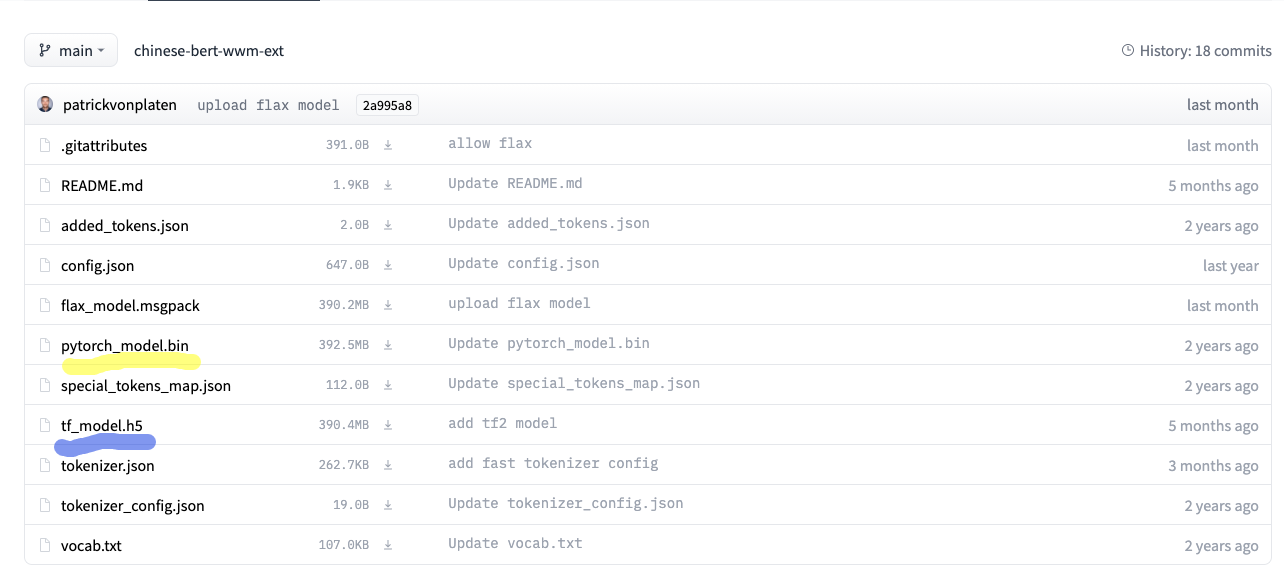

In the given image, `.bin` could denote existence of a pytorch model, while `.h5` could denote existence of a tensorflow model. Lets try plotting with this logic and see.

In [ ]:
def is_tf_torch_present_by_files(x):
    is_tf, is_torch = False, False
    for y in x:
        if '.h5' in y:
            is_tf = True
        if '.bin' in y:
            is_torch = True
    if is_tf and is_torch:
        return "Both"
    elif is_tf:
        return "Tensorflow"
    elif is_torch:
        return "PyTorch"

In [ ]:
df["tf_torch_by_files"] = df["files"].apply(is_tf_torch_present_by_files)
df_temp = df["tf_torch_by_files"].value_counts().reset_index()
px.pie(df_temp, values="tf_torch_by_files", names="index", title="Model availability Pytorch vs Tensorflow (based on Files)")

Observations:
- Both the approaches of using tag vs filenames lead to similar ratios present.
- PyTorch seems to be a dominating presence in modelhub as of now.

### Number of times model is downloaded Pytorch,Tf or both

In [ ]:
df_temp = df[["tf_torch", "downloads_last_month"]].groupby("tf_torch").sum().reset_index()
px.pie(df_temp, values="downloads_last_month", names="tf_torch", title="Share of Downloads between Tf vs Torch models")

Observations:
- Tensorflow-only models account for only **0.11% of downloads**.
- Even if models containing both tf and torch were **10% in number**, they account for **64% of the downloads**.

### Are the models updated recently?
We don't have `createdAt` in the dataset. Although `lastModified` is available. Using that as proxy, we can try visualizing when were the models last updated.

In [ ]:
# First we need to convert it into datetime format
df["lastModified"] = pd.to_datetime(df["lastModified"])

In [ ]:
# Let's create a new column year-month, eg: 2020-01 denoting Jan20
def get_year_month(x):
    return str(x.year) + "-" + str(x.month)
df["year"] = df["lastModified"].dt.year
df["month"] = df["lastModified"].dt.month
df["year-month"] = df["lastModified"].apply(lambda x: get_year_month(x))

In [ ]:
df_temp = df[["year-month", "year", "month"]].value_counts().reset_index().sort_values(["year", "month"])
px.line(df_temp, x="year-month", y=0, title="Freshness of models", labels={"0": "Count of models"})

Observations:
- Most of the models are updated very recently
- Number's a lot higher in May, but that could be due to a lot of new models added. Since we only have `lastModified` info, it's not possible to investigage further as it'd need a field like `createdAt`.
- Oldest available model is from Dec2019
- Three peaks are observed when more models are updated `August-2020`, `Jan-2021` and `May-2021`. 

### Heatmap: When are most models uploaded/updated?

In [ ]:
# We need to derive two new columns from datetime `lastModified` for our heatmap
df["dayofweek"] = df["lastModified"].dt.day_name()
df["dayofweekint"] = df["lastModified"].dt.dayofweek
df["hour"] = df["lastModified"].dt.hour

In [ ]:
df_temp = df[["dayofweek", "hour", "modelId", "dayofweekint"]].groupby(["dayofweek","dayofweekint", "hour"]).count().reset_index()

In [ ]:
df_temp = df_temp.reset_index().sort_values(["dayofweekint","hour"])
def df_to_plotly(df, countCol):
    return {'z': df[countCol].tolist(),
            'x': df["dayofweek"].tolist(),
            'y': df["hour"].tolist()}
import plotly.graph_objects as go
fig = go.Figure(data=go.Heatmap(df_to_plotly(df_temp, countCol="modelId")))
fig.show()

#### When are Huggingface published models uploaded/updated?

In [ ]:
df_temp = df[df["publishedBy"] == "huggingface"][["dayofweek", "hour", "modelId", "dayofweekint"]].groupby(["dayofweek","dayofweekint", "hour"]).count().reset_index()
df_temp = df_temp.reset_index().sort_values(["dayofweekint","hour"])
def df_to_plotly(df, countCol):
    return {'z': df[countCol].tolist(),
            'x': df["dayofweek"].tolist(),
            'y': df["hour"].tolist()}
import plotly.graph_objects as go
fig = go.Figure(data=go.Heatmap(df_to_plotly(df_temp, countCol="modelId")))
fig.show()

Observations:
- Someone else needs to cross-check this as I can't believe my eyes. Even though the timezone is UTC and folks are spread across globe, but it looks like **out of 75 models uploaded by HF, *zero* of them are uploaded(lastUploaded) on a weekend** 

#### Huggingtweets update heatmap

In [ ]:
df_temp = df[df["publishedBy"] == "huggingtweets"][["dayofweek", "hour", "modelId", "dayofweekint"]].groupby(["dayofweek","dayofweekint", "hour"]).count().reset_index()
df_temp = df_temp.reset_index().sort_values(["dayofweekint","hour"])
def df_to_plotly(df, countCol):
    return {'z': df[countCol].tolist(),
            'x': df["dayofweek"].tolist(),
            'y': df["hour"].tolist()}
import plotly.graph_objects as go
fig = go.Figure(data=go.Heatmap(df_to_plotly(df_temp, countCol="modelId")))
fig.show()

### Most used tags

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud().generate(" ".join(sum(df["tags"].dropna().to_list(),[])))
plt.figure(figsize=(14,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

End notes:
- Further analysis to be done in coming versions on tags and files
- README content is unexplored and parsing it will be a challenging problem

Please upvote if you liked the notebook and share any errors in comments. :)